In [13]:
def fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    Reference
    ---------
    J. Krapac, J. Verbeek, F. Jurie.  Modeling Spatial Layout with Fisher
    Vectors for Image Categorization.  In ICCV, 2011.
    http://hal.inria.fr/docs/00/61/94/03/PDF/final.r1.pdf
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

In [17]:
def compute_SFV(X):
    K = 10
    gmm = GaussianMixture(n_components=K, covariance_type='diag')
    gmm.fit(X)
    return fisher_vector(X, gmm)

In [236]:
SFV = []
labels = []

for f in type1_files:
    X = tools.read_json(f)
    X = scale_drawing(X)
    fv = compute_SFV(X)
    
    SFV.append(fv)
    labels.append(0)
    
for f in type2_files:
    X = tools.read_json(f)
    X = scale_drawing(X)
    fv = compute_SFV(X)
    
    SFV.append(fv)
    labels.append(1)
    
SFV = np.array(SFV)
labels = np.array(labels)

In [241]:
import itertools
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])



from scipy import linalg

def plot_gmm(gmm):

    means = gmm.means_
    covariances = gmm.covariances_
    
    ax = plt.subplot(111)

    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        
        square_covar = np.diag(covar)
        
        v, w = linalg.eigh(square_covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

(-1, 1)

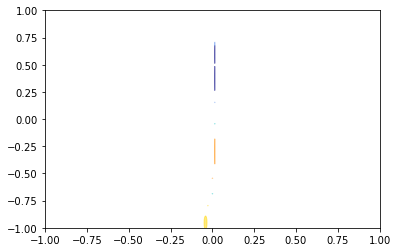

In [242]:
X = scale_drawing(X)
gmm.fit(X)
# plt.scatter(X[:,0], X[:,1])
plot_gmm(gmm)
plt.xlim([-1,1])
plt.ylim([-1,1])
# plt.axis('equal')